# LAB 5 - CNN (Text)

Task: You have to implement the architecture given in the paper given below that measures the sensitivity of CNN to sentence classification.

https://aclanthology.org/I17-1026.pdf

Use the TREC dataset given at the link : 

https://github.com/as3eem/Deep-Learning---Tutorials/tree/main/LAB%205%20-%20CNN%20(Text)

Dataset is based on the task of question classification with 6 coarse-level classes and 47 fine-level classes
separated by colon followed by a space and the question text i.e <coarse - label : fine-label<space><question_text>>. 

**Text Representation: Use Word2Vec Representation** 

For the assignment level you can work on coarse label targets only.


## Relevant Libraries

In [45]:
import os
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from collections import defaultdict
from tqdm import tqdm_notebook
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim
import torch.nn.functional as F
import random
import numpy as np
from collections import Counter, OrderedDict
import nltk
import re


%matplotlib inline

In [46]:
flatten = lambda l: [item for sublist in l for item in sublist]
random.seed(1024)

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor
ByteTensor = torch.ByteTensor

In [47]:
data = open(r'Trec_Train_dataset.txt', 'r', encoding='latin-1').readlines()
data = [[d.split(':')[1][:-1], d.split(':')[0]] for d in data]

In [48]:
X, y = list(zip(*data))

In [49]:
X[22],y[22]

('ind Name 11 famous martyrs .', 'HUM')

In [50]:
X = list(X)

In [51]:
for i, x in enumerate(X):
    X[i] = re.sub('\d', '#', x).split()

In [52]:
X[22]

['ind', 'Name', '##', 'famous', 'martyrs', '.']

In [53]:
vocab = list(set(flatten(X)))[:6500]
print('len(y)=',len(set(y)),'  set(y)=',set(y))

len(y)= 6   set(y)= {'NUM', 'DESC', 'LOC', 'ENTY', 'HUM', 'ABBR'}


In [54]:
def getBatch(batch_size, train_data):
    random.shuffle(train_data)
    sindex = 0
    eindex = batch_size
    while eindex < len(train_data):
        batch = train_data[sindex: eindex]
        temp = eindex
        eindex = eindex + batch_size
        sindex = temp
        yield batch
    
    if eindex >= len(train_data):
        batch = train_data[sindex:]
        yield batch
        
def pad_to_batch(batch):
    x,y = zip(*batch)
    max_x = max([s.size(1) for s in x])
    x_p = []
    for i in range(len(batch)):
        if x[i].size(1) < max_x:
            x_p.append(torch.cat([x[i], Variable(LongTensor([word2index['<PAD>']] * (max_x - x[i].size(1)))).view(1, -1)], 1))
        else:
            x_p.append(x[i])
    return torch.cat(x_p), torch.cat(y).view(-1)


def prepare_sequence(seq, to_index):
    idxs = list(map(lambda w: to_index[w] if to_index.get(w) is not None else to_index["<UNK>"], seq))
    return Variable(LongTensor(idxs))

In [55]:
word2index={'<PAD>': 0, '<UNK>': 1}

for vo in vocab:
    if word2index.get(vo) is None:
        word2index[vo] = len(word2index)
        
index2word = {v:k for k, v in word2index.items()}

target2index = {}

for cl in set(y):
    if target2index.get(cl) is None:
        target2index[cl] = len(target2index)

index2target = {v:k for k, v in target2index.items()}

In [88]:
index2target

{0: 'NUM', 1: 'DESC', 2: 'LOC', 3: 'ENTY', 4: 'HUM', 5: 'ABBR'}

In [57]:
X_p, y_p = [], []
for pair in zip(X,y):
    X_p.append(prepare_sequence(pair[0], word2index).view(1, -1))           
    y_p.append(Variable(LongTensor([target2index[pair[1]]])).view(1, -1))
    
data_p = list(zip(X_p, y_p))
random.shuffle(data_p)

test_data = data_p[: int(len(data_p) * 0.2)]
train_data = data_p[int(len(data_p) * 0.2):]

In [58]:
X_p[0]

tensor([[4980,    1, 4026,    1, 5801,    1, 2296, 4879,  635, 6322, 4915]])

In [59]:
data_p[0]

(tensor([[6471,    1, 5751, 3796, 4026,    3,    1,    1, 4915]]),
 tensor([[0]]))

In [60]:
len(train_data),len(test_data)

(4362, 1090)

## Word2Vec Representation

In [61]:
!wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

--2021-08-07 10:27:16--  https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.241.198
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.241.198|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.



In [62]:
len(train_data),len(test_data)

(4362, 1090)

In [63]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format(r'/content/GoogleNews-vectors-negative300.bin.gz', binary=True)

len(model.index2word)

3000000

In [64]:
pretrained = []
for key in word2index.keys():
    try:
        pretrained.append(model[word2index[key]])
    except:
        pretrained.append(np.random.randn(100))
pretrained_vectors = np.vstack(pretrained)

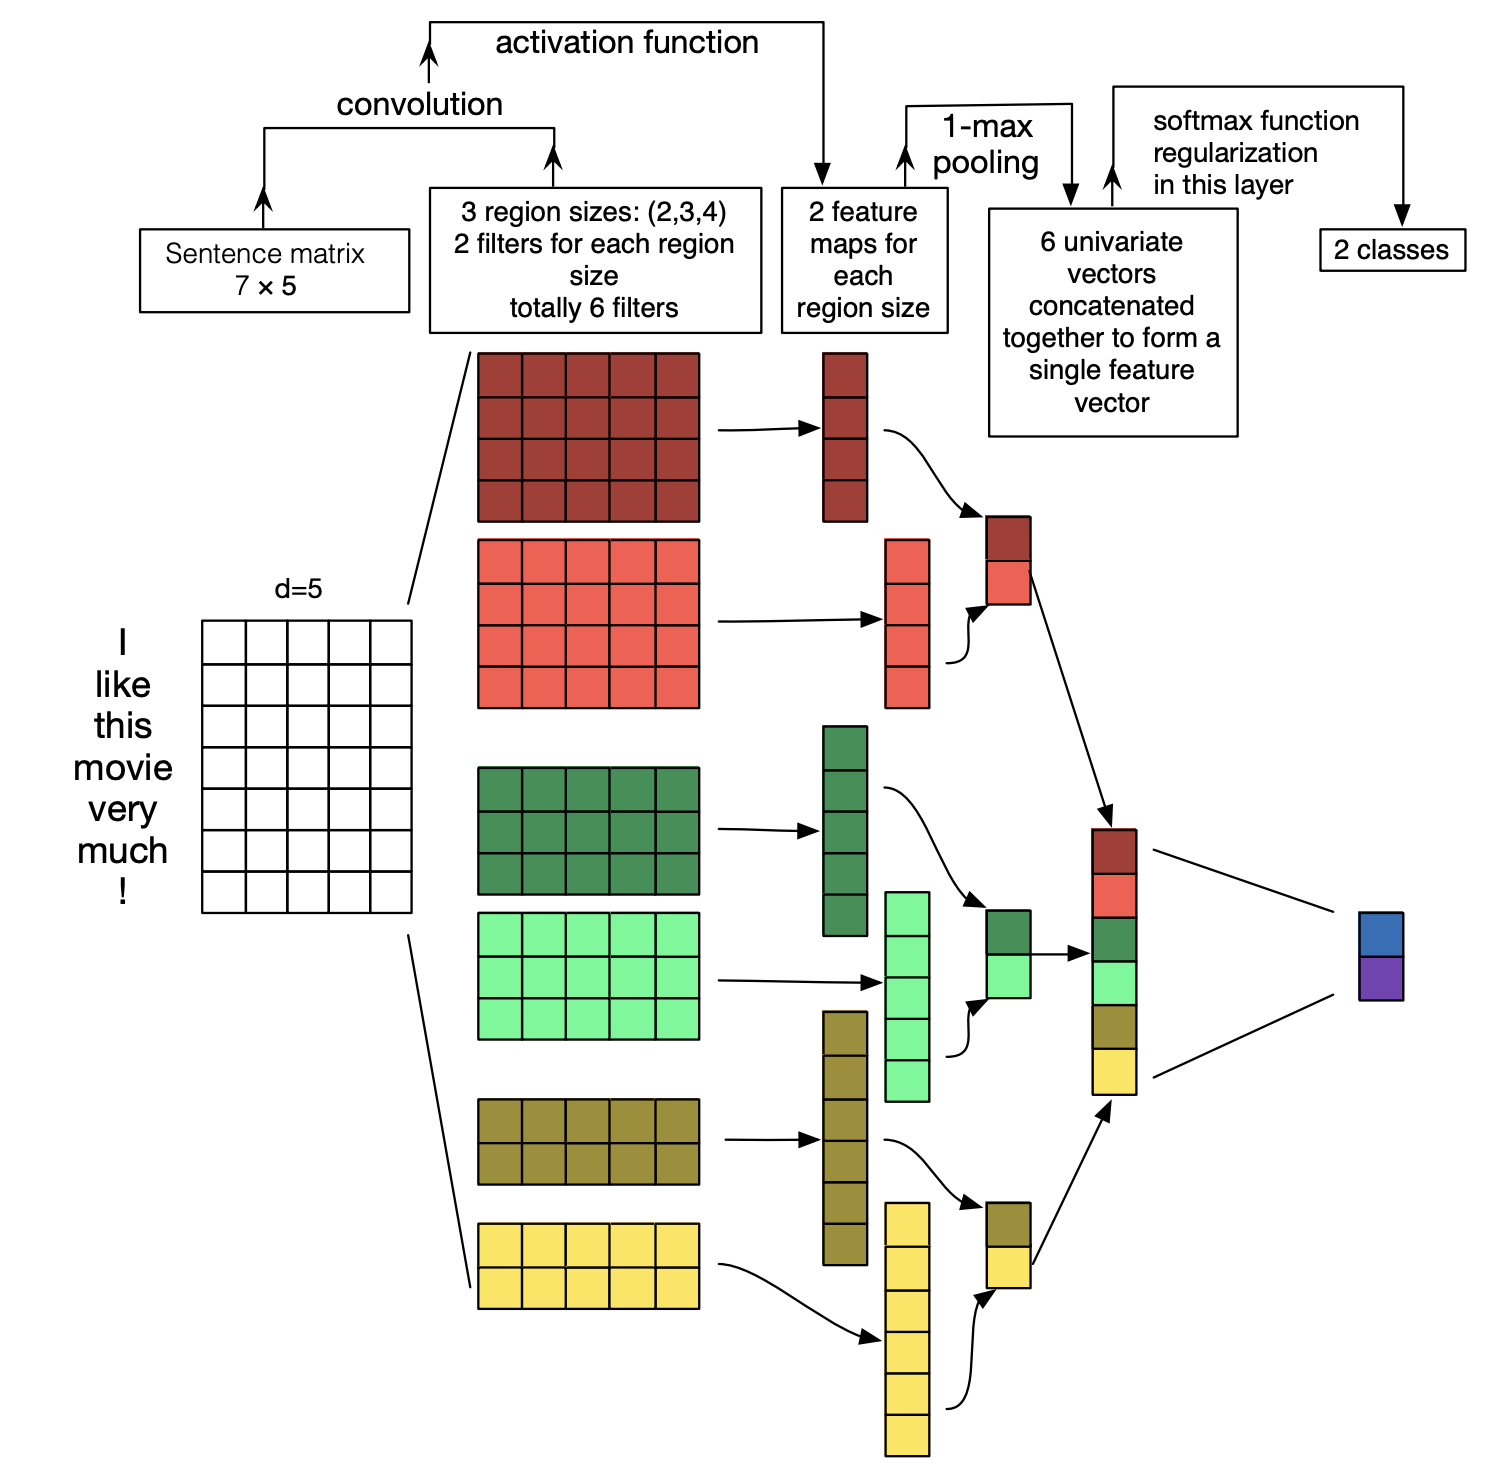

## Architecture Implementation

In [65]:
class  CNNEncoder(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, output_size, kernel_dim=100, kernel_sizes=(3, 4, 5), dropout=0.5):
        super(CNNEncoder,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)      #(v,d)
        self.convs = nn.ModuleList([nn.Conv2d(1, kernel_dim, (K, embedding_dim))     for K in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(kernel_sizes) * kernel_dim, output_size)  #(6,300)
    
    
    def init_weights(self, pretrained_word_vectors, is_static=False):
        self.embedding.weight = nn.Parameter(torch.from_numpy(pretrained_word_vectors).float())
        if is_static:
            self.embedding.weight.requires_grad = False


    def forward(self, inputs, is_training=False):
        inputs = self.embedding(inputs).unsqueeze(1)
        inputs = [F.relu(conv(inputs)).squeeze(3)    for conv in self.convs]
        inputs = [F.avg_pool1d(i, i.size(2)).squeeze(2) for i in inputs]
        concated = torch.cat(inputs, 1)

        if is_training:
            concated = self.dropout(concated)
        out = self.fc(concated)
        return F.log_softmax(out,1)
    

BATCH_SIZE = 16
KERNEL_SIZES = [3,4,5]
KERNEL_DIM = 100
LR = 0.01
EPOCH = 10

model = CNNEncoder(len(word2index), 100, len(target2index), KERNEL_DIM, KERNEL_SIZES)


model.init_weights(pretrained_vectors)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CNNEncoder(
  (embedding): Embedding(6502, 100)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=300, out_features=6, bias=True)
)

In [67]:
len(data_p)

5452

## Model Training & Inference

In [68]:
for epoch in range(EPOCH):
    losses = []
    for i,batch in enumerate(getBatch(BATCH_SIZE, train_data)):
        inputs,targets = pad_to_batch(batch)

        # forward pass
        preds = model(inputs.to(device), True)
        
        # calcualte loss
        loss = loss_function(preds, targets.to(device))
        losses.append(loss.data.tolist())
        
        # backpropagate
        loss.backward()

        # update the weights
        optimizer.step()
        
        # Dont forget to zero the grad
        model.zero_grad()
        
        if i % 100 == 0:
            print("[%d/%d] mean_loss : %0.5f" %(epoch, EPOCH, np.mean(losses)))
            losses = []

[0/10] mean_loss : 1.81683
[0/10] mean_loss : 0.95803
[0/10] mean_loss : 0.49909
[1/10] mean_loss : 0.24686
[1/10] mean_loss : 0.23449
[1/10] mean_loss : 0.24173
[2/10] mean_loss : 0.25914
[2/10] mean_loss : 0.12281
[2/10] mean_loss : 0.09748
[3/10] mean_loss : 0.33790
[3/10] mean_loss : 0.07074
[3/10] mean_loss : 0.07353
[4/10] mean_loss : 0.02753
[4/10] mean_loss : 0.06312
[4/10] mean_loss : 0.02800
[5/10] mean_loss : 0.00121
[5/10] mean_loss : 0.05264
[5/10] mean_loss : 0.04589
[6/10] mean_loss : 0.10471
[6/10] mean_loss : 0.03961
[6/10] mean_loss : 0.03807
[7/10] mean_loss : 0.00001
[7/10] mean_loss : 0.04100
[7/10] mean_loss : 0.03727
[8/10] mean_loss : 0.00014
[8/10] mean_loss : 0.02670
[8/10] mean_loss : 0.08071
[9/10] mean_loss : 0.00010
[9/10] mean_loss : 0.07098
[9/10] mean_loss : 0.10524


In [69]:

for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

embedding.weight 	 torch.Size([6502, 100])
convs.0.weight 	 torch.Size([100, 1, 3, 100])
convs.0.bias 	 torch.Size([100])
convs.1.weight 	 torch.Size([100, 1, 4, 100])
convs.1.bias 	 torch.Size([100])
convs.2.weight 	 torch.Size([100, 1, 5, 100])
convs.2.bias 	 torch.Size([100])
fc.weight 	 torch.Size([6, 300])
fc.bias 	 torch.Size([6])
state 	 {0: {'step': 2730, 'exp_avg': tensor([[-4.5172e-04,  2.9422e-05, -3.3102e-04,  ...,  1.2077e-04,
          2.3883e-04, -1.5259e-03],
        [-6.1299e-03, -3.7171e-03,  1.0808e-02,  ..., -5.0288e-03,
          4.3330e-04,  2.4348e-03],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [-5.6052e-45,  5.6052e-45, -5.6052e-45,  ...,  5.6052e-45,
          5.6052e-45, -5.6052e-45],
        [ 5.6052e-45,  5.6052e-45, -5.6052e-45,  ...,  5.6052e-45,
          5.6052e-45,  5.6052e-45],
        [-1.0295e-16, -5.5181e-17,  4.4160e-17,  ...,  7.3511e-17,
         -4.4377e-17,  8.261

In [70]:
# torch.save(model.state_dict(),'/content/Trec_Train_dataset.model')

In [71]:
len(test_data)

1090

In [72]:
y_probs = []
y_preds = []
y_true = []
for i,test in enumerate(test_data):
      try:
          pred = model(test[0].to(device)).max(1)[1]
          y_probs.append(model(test[0].to(device)).tolist()[0])
          pred = pred.data.tolist()[0]
          target = test[1].data.tolist()[0][0]
          y_preds.append(pred)
          y_true.append(target)
      except Exception as e:
          print(e)

Calculated padded input size per channel: (4 x 100). Kernel size: (5 x 100). Kernel size can't be greater than actual input size
Calculated padded input size per channel: (4 x 100). Kernel size: (5 x 100). Kernel size can't be greater than actual input size


In [73]:
y_preds[3],y_probs[3]

(2,
 [-2.2545526027679443,
  -1.1622260808944702,
  -0.9082530736923218,
  -2.070990562438965,
  -2.9640369415283203,
  -6.577393531799316])

## Results

In [74]:
!python3 -m pip install scikit-plot

In [75]:
from scikitplot.metrics import plot_roc

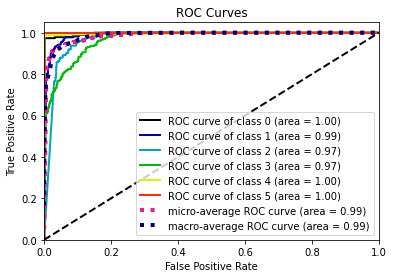

In [76]:
plot_roc(y_true, y_probs)

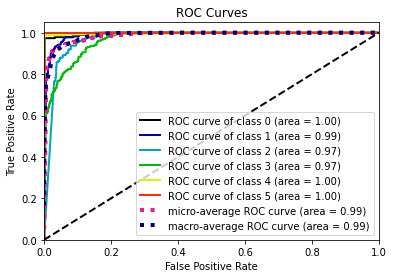

In [77]:
plot_roc(y_true, y_probs)

In [78]:
from sklearn.metrics import classification_report

target_names = ['LOC', 'NUM', 'ENTY', 'ABBR', 'DESC', 'HUM']
print(classification_report(y_true, y_preds, target_names=target_names))

              precision    recall  f1-score   support

         LOC       0.96      0.97      0.97       190
         NUM       0.92      0.90      0.91       226
        ENTY       0.72      0.90      0.80       175
        ABBR       0.86      0.72      0.78       233
        DESC       0.99      0.99      0.99       240
         HUM       1.00      1.00      1.00        24

    accuracy                           0.90      1088
   macro avg       0.91      0.91      0.91      1088
weighted avg       0.90      0.90      0.90      1088



In [79]:
from sklearn.metrics import classification_report

target_names = ['LOC', 'NUM', 'ENTY', 'ABBR', 'DESC', 'HUM']
print(classification_report(y_true, y_preds, target_names=target_names))

              precision    recall  f1-score   support

         LOC       0.96      0.97      0.97       190
         NUM       0.92      0.90      0.91       226
        ENTY       0.72      0.90      0.80       175
        ABBR       0.86      0.72      0.78       233
        DESC       0.99      0.99      0.99       240
         HUM       1.00      1.00      1.00        24

    accuracy                           0.90      1088
   macro avg       0.91      0.91      0.91      1088
weighted avg       0.90      0.90      0.90      1088



In [80]:
a = np.array(y_preds)
b = np.zeros((a.size, a.max()+1))
b[np.arange(a.size),a] = 1
b

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

In [81]:
b[0]

array([1., 0., 0., 0., 0., 0.])

In [82]:
y_score_refine = []

for elem in y_probs:
#   # print(elem)
  y_score_refine.append(np.array(elem))
#   # break